## KarpovCourses. Продуктовая аналитика 
### Сегментация клиентов в Python 
 
### RFM-анализ

In [86]:
import pandas as pd
import numpy as np


# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [87]:
orders = pd.read_csv('https://stepik.org/media/attachments/lesson/413464/RFM_ht_data.csv',sep=',')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
orders.head()

InvoiceNo CustomerCode InvoiceDate   Amount
0  C0011810010001     19067290  2020-09-01  1716.00
1  C0011810010017     13233933  2020-09-01  1489.74
2  C0011810010020     99057968  2020-09-01   151.47
3  C0011810010021     80007276  2020-09-01   146.72
4  C0011810010024     13164076  2020-09-01   104.00

In [89]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [90]:
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])

In [91]:
orders['CustomerCode'] = orders['CustomerCode'].apply(str)

In [92]:
orders['InvoiceNo'] = orders['InvoiceNo'].apply(str)

In [93]:
orders['CustomerCode'].apply(type).value_counts()

<class 'str'>    332730
Name: CustomerCode, dtype: int64

In [94]:
last_date = orders.InvoiceDate.max()

In [95]:

rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)


In [96]:
rfmSegmentation = rfmTable

## Какое максимальное кол-во покупок было совершено одним пользователем?

In [97]:
rfmSegmentation.sort_values('frequency', ascending = False)

recency  frequency  monetary_value
CustomerCode                                    
19057820            0        204       104871.80
13215452            0        113        85334.40
13032521            0        106       389309.92
19080880           27         99       169930.72
99003061            0         90       398759.35
...               ...        ...             ...
13272861            0          1         3312.62
13272871           12          1          684.80
13272875            4          1         4284.89
13272878            5          1          366.01
14000778            6          1         1714.00

[123733 rows x 3 columns]

In [98]:

def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [99]:
quantiles = rfmSegmentation.quantile(q=[0.25,0.5,0.75])

In [100]:
quantiles

recency  frequency  monetary_value
0.25      2.0        1.0          765.00
0.50      8.0        2.0         1834.48
0.75     16.0        3.0         4008.84

In [101]:

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)+ rfmSegmentation.F_Quartile.map(str)+ rfmSegmentation.M_Quartile.map(str)

In [104]:
rfmSegmentation.head()

recency  frequency  monetary_value  R_Quartile  F_Quartile  \
CustomerCode                                                               
02213019           19          1         1609.20           4           4   
02213042           22          3         9685.48           4           2   
02213071           29          1          415.00           4           4   
02213088           23          1          305.00           4           4   
02213092           25          1         1412.88           4           4   

              M_Quartile RFMClass  
CustomerCode                       
02213019               3      443  
02213042               1      421  
02213071               4      444  
02213088               4      444  
02213092               3      443

In [102]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)


F_Quartile      1     2     3      4
R_Quartile                          
1           14433  4671  5795   6074
2            9634  5889  8633  10399
3            3091  3748  7734  13263
4             542  1311  5415  23101

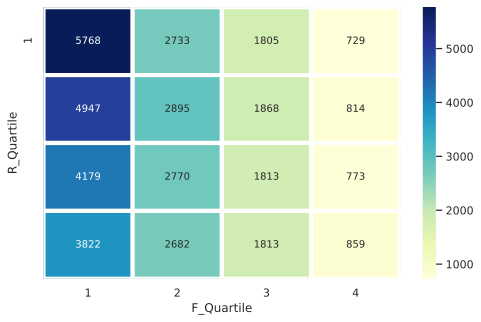

In [103]:

rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

## Сколько пользователей попало в сегмент 111?

In [109]:
rfmSegmentation.query("RFMClass == '111'").shape[0]

9705

In [110]:
rfmSegmentation.query("RFMClass == '311'").shape[0]

1609

## В каком RFM-сегменте самое большое кол-во пользователей?
## В каком RFM-сегменте самое маленькое кол-во пользователей?

In [111]:
rfmSegmentation.RFMClass.value_counts()

444    10624
111     9705
443     6729
344     6593
211     5847
       ...  
424       63
114       60
214       60
314       33
414        2
Name: RFMClass, Length: 64, dtype: int64